# Charging the data

## 1. Import libraries

In [1]:
import numpy as np

from skimage import filters

from scipy.interpolate import interp1d


from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset

import os

from tqdm import tqdm 

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from pathlib import Path

In [2]:
plt.rcParams.update({
  'axes.titlesize': 'x-large',  # heading 1
  'axes.labelsize': 'large',   # heading 2
  'xtick.labelsize': 'medium',         # fontsize of the ticks
  'ytick.labelsize': 'medium',         # fontsize of the ticks
  'font.family': 'serif',        # Font family
  'text.usetex': False,          # Do not use LaTeX for text rendering
  'figure.figsize': (10, 8),     # Default figure size
  'savefig.dpi': 300,            # High resolution for saving figures
  'savefig.format': 'png',       # Default format for saving figures
  'legend.fontsize': 'large',  # Font size for legends
  'lines.linewidth': 2,          # Line width for plots
  'lines.markersize': 8,         # Marker size for plots,
  'axes.formatter.useoffset': False,  # Disable offset
  'axes.formatter.use_mathtext': True,  # Use scientific notation
  'axes.formatter.limits': (-3, 3),  # Use scientific notation for values over 10^2
  'axes.labelsize': 'large',     # Font size for axes labels
  'figure.titlesize': 'xx-large' # Font size for suptitles (heading 1)
})

## 2. Charge the data

### 2.1 Charge the raw data

First let's define the path to the data and use a testing file. Also, some quantities useful for the dimensiones to be treated later in the code.

In [3]:
images_output = Path("../thesis_images")
if not os.path.exists(images_output):
    os.makedirs(images_output)

In [4]:
ptm = Path("/media/juanessao2000/hdd/PRINCIPAL-2023-2/PROYECTOS/PROYECTO_DL/data")
filename = "080000"

nlam = 300 #this parameter is useful when managing the Stokes parameters #wavelenght interval - its from 6300 amstroengs in steps of 10 amstroengs
nx = 480
ny = 256 #height axis
nz = 480

Charge the data corresponding to temperature, density, magnetic field and velocity

In [5]:
print(f"""
        ######################## 
        Reading {filename} MuRAM data...
        ######################## 
              """)

print("Charging temperature ...")
mtpr = np.load(ptm / "geom_height" / f"mtpr_{filename}.npy").flatten()
print("mtpr shape:", mtpr.shape)

print("Charging magnetic field vector...")
mbxx = np.load(ptm / "geom_height" / f"mbxx_{filename}.npy")
mbyy = np.load(ptm / "geom_height" / f"mbyy_{filename}.npy")
mbzz = np.load(ptm / "geom_height" / f"mbzz_{filename}.npy")

coef = np.sqrt(4.0*np.pi) #cgs units conversion300

mbxx=mbxx*coef
mbyy=mbyy*coef
mbzz=mbzz*coef
print("mbxx shape:", mbxx.shape)
print("mbyy shape:", mbyy.shape)
print("mbzz shape:", mbzz.shape)

print("Charging density...")
mrho = np.load(ptm / "geom_height" / f"mrho_{filename}.npy")
print("mrho shape:", mrho.shape)

print("Charge velocity...")
mvxx = np.load(ptm / "geom_height" / f"mvxx_{filename}.npy")
mvyy = np.load(ptm / "geom_height" / f"mvyy_{filename}.npy")
mvzz = np.load(ptm / "geom_height" / f"mvzz_{filename}.npy")
print("mvxx shape:", mvxx.shape)
print("mvyy shape:", mvyy.shape)
print("mvzz shape:", mbzz.shape)

mvxx = mvxx/mrho
mvyy = mvyy/mrho
mvzz = mvzz/mrho

muram_box = np.stack([mtpr, mrho, mbxx, mbyy, mbzz, mvxx, mvyy, mvzz], axis=-1)
print(f"""
        ######################## 
        Finished!
        ######################## 
              """)

del mtpr, mrho, mbxx, mbyy, mbzz, mvxx, mvyy, mvzz


        ######################## 
        Reading 080000 MuRAM data...
        ######################## 
              
Charging temperature ...
mtpr shape: (58982400,)
Charging magnetic field vector...
mbxx shape: (58982400,)
mbyy shape: (58982400,)
mbzz shape: (58982400,)
Charging density...
mrho shape: (58982400,)
Charge velocity...
mvxx shape: (58982400,)
mvyy shape: (58982400,)
mvzz shape: (58982400,)

        ######################## 
        Finished!
        ######################## 
              


For the vertical representation, we'll take the mean value for each surface.

In [6]:
from scipy.interpolate import make_interp_spline

domain_heights = np.array(range(0, 256)) * 10
mean_T = muram_box[:,0].reshape(nx, ny, nz).mean(axis = (0,2)) 
T_indices = np.argsort(mean_T)
mean_T = mean_T[T_indices]
domain_heights = domain_heights[T_indices]

Teff = 5780
height_T_func = make_interp_spline(mean_T, domain_heights, k=3)
height_Teff = height_T_func(Teff)
print(f"Height at Teff = {height_Teff} km")

domain_heights = domain_heights - height_Teff
domain_heights = np.sort(domain_heights)




Height at Teff = 1897.4793049627453 km


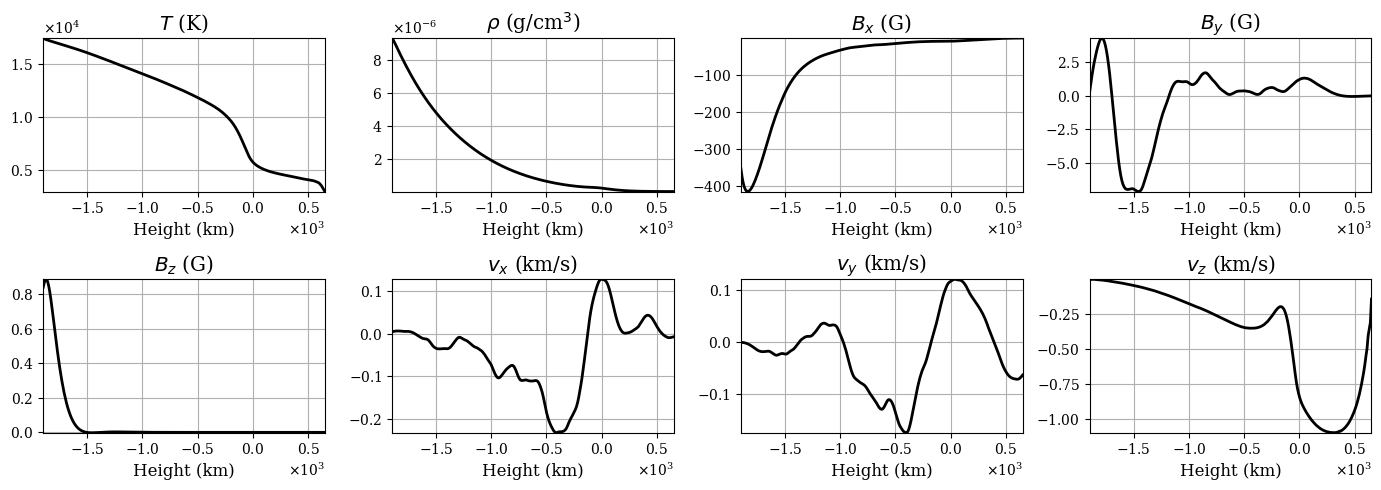

In [8]:
fig, ax = plt.subplots(2, 4, figsize=(4*3.5, 2*2.5))

quantities = [
    (0, r"$T$", "K", "inferno"),
    (1, r"$\rho$", r"g/cm$^3$", "summer"),
    (2, r"$B_x$", "G", "PuOr"),
    (3, r"$B_y$", "G",  "PuOr"),
    (4, r"$B_z$", "G", "PuOr"),
    (5, r"$v_x$", "km/s", "bwr_r"),
    (6, r"$v_y$", "km/s", "bwr_r"),
    (7, r"$v_z$", "km/s", "bwr_r")
]


for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[:,param_idx].reshape(nx, ny, nz).mean(axis = (0,2)) 
  if title in [r"$v_x$", r"$v_y$", r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
    
  iax = ax[i // 4, i % 4]
  
  iax.plot(domain_heights, data, "k")
  iax.set_xlabel("Height (km)")
  iax.set_title(f"{title} ({unit})")
  iax.set_xlim(domain_heights.min(), domain_heights.max())
  iax.grid(True)
  iax.set_ylim(data.min(), data.max())
plt.tight_layout(w_pad=1.0, h_pad=1.0)
fig.savefig(images_output / "muram_box_mean_profile.png", dpi=300)

plt.show()


Let's plot them to check their distribution along height and over a surface

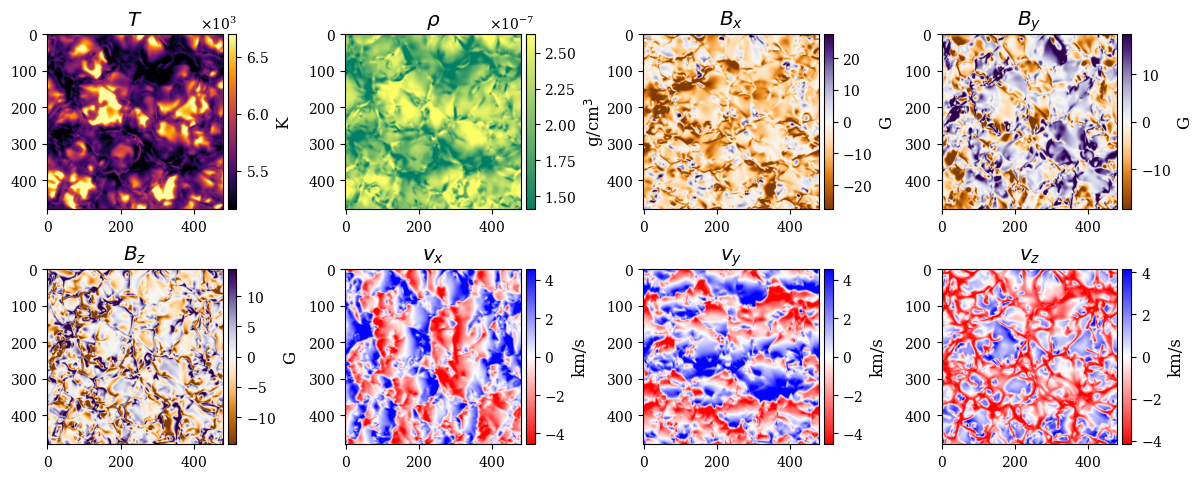

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

height_pix = 190
fig, ax = plt.subplots(2, 4, figsize=(4*3, 2*2.5))
for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[:,param_idx].reshape(nx, ny, nz)[:, height_pix, :]
  if title in [r"$v_x$", r"$v_y$", r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
  if title in [r"$B_x$", r"$B_y$",r"$B_z$", r"$v_x$", r"$v_y$", r"$v_z$"]:  # Magnetic field components and velocity need symmetric colorbars
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
  else:
    # Calculate quantiles for colorbar limits based on original data
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = orig_q5
    vmax = orig_q95
  im = ax[i // 4, i % 4].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax)
  ax[i // 4, i % 4].set_title(title)
  divider = make_axes_locatable(ax[i // 4, i % 4])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax, label=unit)
plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "muram_box_fixed_height.png", dpi=300)

plt.show()

In [18]:
first_positive_index = np.argmax(domain_heights > 0)
print(first_positive_index)

190


### 2.2 Non azimuth ambiguity components

As you may know, the magnetic field has an azimuth ambiguity in the sense that $B(\varphi) = B(\varphi + 180^\circ)$, then we may define some new components that are directly related to the stokes parameters, whose definition comes from the weak field aprosimation

\begin{equation}
\begin{split}
B_{\text{Q}} =& \text{sign}(B_x^2 - B_y^2) |B_x^2 - B_y^2|^{1/2}\\
B_{\text{U}} =& \text{sign}(B_x B_y) |B_x B_y|^{1/2}\\
B_{\text{V}} =& B_z
\end{split}
\end{equation}

In [10]:

muram_box[:,2] = np.sign(muram_box[:,2]**2 - muram_box[:,3]**2)*np.sqrt(np.abs(muram_box[:,2]**2 - muram_box[:,3]**2))
muram_box[:,3] = np.sign(muram_box[:,2]*muram_box[:,3])*np.sqrt(np.abs( muram_box[:,2]*muram_box[:,3]))

Let's plot them to check their vertical and surface distribution.

In [11]:
modified_quantities = [
    (0, r"$T$", "K", "inferno"),
    (1, r"$\rho$", r"g/cm$^3$", "spring"),
    (2, r"$B_Q$", "G", "PuOr"),
    (3, r"$B_U$", "G",  "PuOr"),
    (4, r"$B_V$", "G", "PuOr"),
    (5, r"$v_x$", "km/s", "bwr_r"),
    (6, r"$v_y$", "km/s", "bwr_r"),
    (7, r"$v_z$", "km/s", "bwr_r")
]


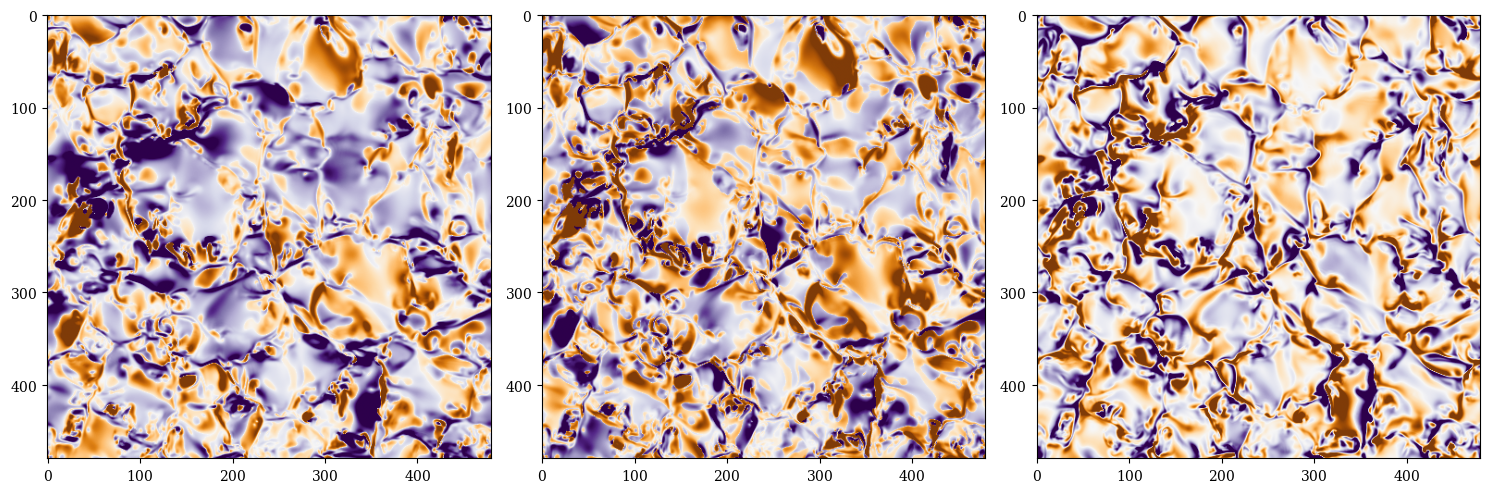

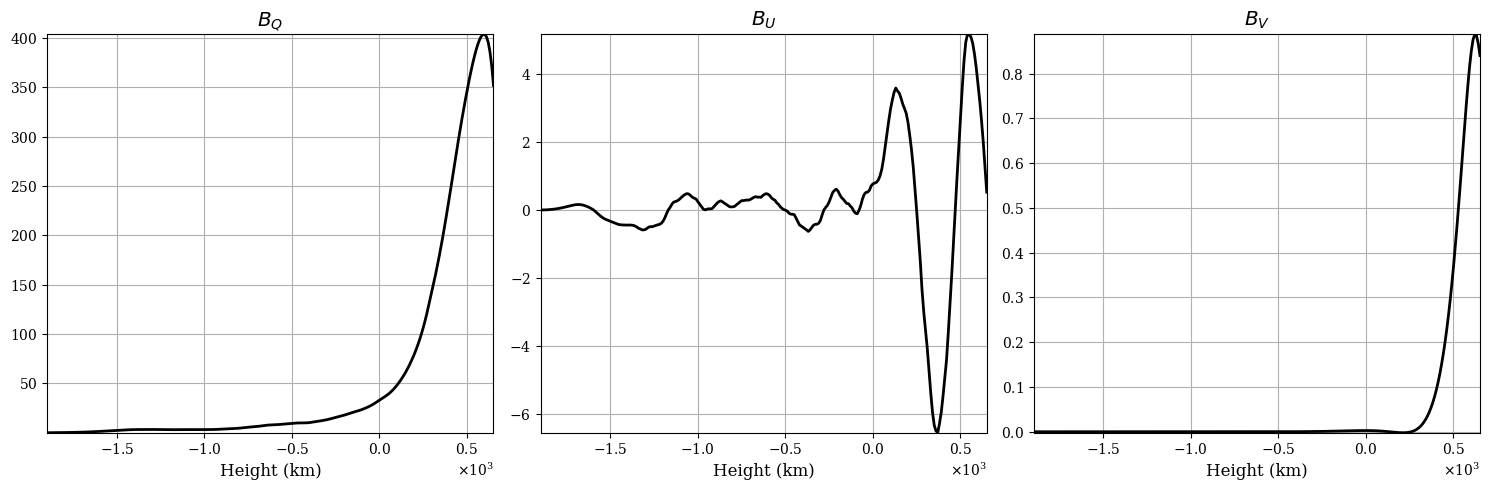

In [12]:
# Plot the modified components of the magnetic field using imshow for the surface at a fixed height
height_pix = 190
fig, ax = plt.subplots(1, 3, figsize=(3*5, 5))
modified_titles = ["$B_Q$", "$B_U$", "$B_V$"]
cmap = "PuOr"

for i, param_idx in enumerate([2, 3, 4]):
    data = muram_box[:, param_idx].reshape(nx, ny, nz)[:, height_pix, :]
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
    im = ax[i].imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)

plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "modified_magnetic_field_fixed_height.png", dpi=300)
plt.show()

# Plot the mean value along height for the modified components of the magnetic field
fig, ax = plt.subplots(1, 3, figsize=(3*5, 5))

for i, param_idx in enumerate([2, 3, 4]):
    data = muram_box[:, param_idx].reshape(nx, ny, nz).mean(axis=(0, 2))
    data = data[T_indices]
    ax[i].plot(domain_heights, data, "k")
    ax[i].set_xlabel("Height (km)")
    ax[i].set_title(modified_titles[i])
    ax[i].set_xlim(domain_heights.min(), domain_heights.max())
    ax[i].grid(True)
    ax[i].set_ylim(data.min(), data.max())

plt.tight_layout(w_pad=1.0, h_pad=1.0)
fig.savefig(images_output / "modified_magnetic_field_mean_profile.png", dpi=300)
plt.show()

In [ ]:
for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[:,param_idx].reshape(nx, ny, nz)[:, height_pix, :]
  if title in [r"$v_x$", r"$v_y$", r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
  if title in [r"$B_x$", r"$B_z$",r"$B_y$", r"$v_x$", r"$v_y$", r"$v_z$"]:  # Magnetic field components and velocity need symmetric colorbars
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
  else:
    # Calculate quantiles for colorbar limits based on original data
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = orig_q5
    vmax = orig_q95
  im = ax[i // 4, i % 4].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax)
  ax[i // 4, i % 4].set_title(title)
  divider = make_axes_locatable(ax[i // 4, i % 4])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax, label=unit)

plt.tight_layout(w_pad=1.0, h_pad=0.001)
plt.show()

### 2.3 Defining atm array

Let's define an array for all the atmosphere quantities to be used. Specifically, we are going to use the temperature, density, the modified components of magnetic field and the line-of-sight component of velocity.

In [ ]:
atm_quant = np.array([mtpr, mrho, mbqq, mbuu, mbvv, mvyy])
atm_quant = np.moveaxis(atm_quant, 0, 1)
atm_quant = np.reshape(atm_quant, (nx,ny,nz,atm_quant.shape[-1]))
atm_quant = np.moveaxis(atm_quant, 1, 2)

print("atm_quant shape:", atm_quant.shape)

atm_quant shape: (480, 480, 256, 6)


### 2.4 Charge the Stokes parameters

Having the atmosphere magnitudes charged, we need to charge now the radiation information contained in the Stokes parameters generated for our simulation.

In [ ]:
print("Charging Stokes vectors...")
stokes = np.load(ptm / "stokes" / f"{filename}_prof.npy")
print("Charged!")
print("stokes shape", stokes.shape)

Charging Stokes vectors...
Charged!
stokes shape (480, 480, 300, 4)


Let's plot the surface image and the wavelength spectra for the same arbitrary pixel we choosed before.

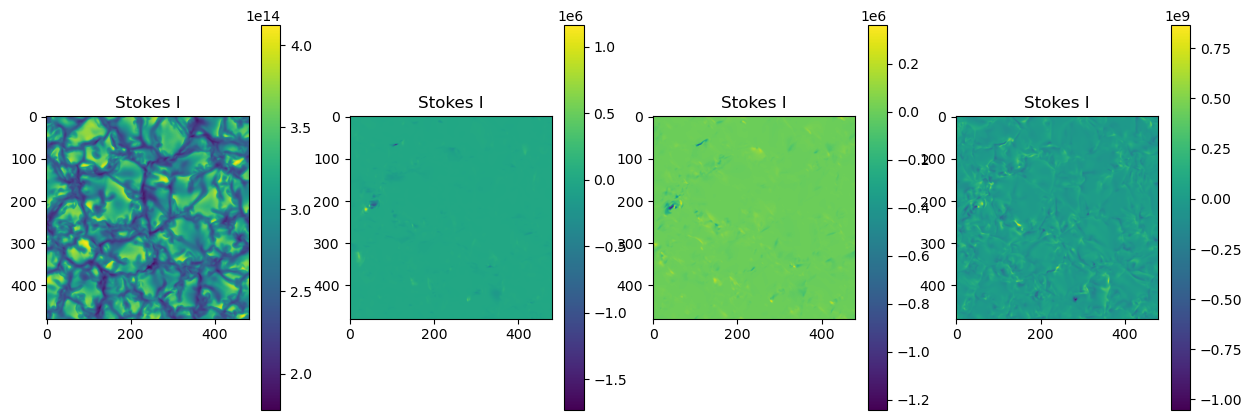

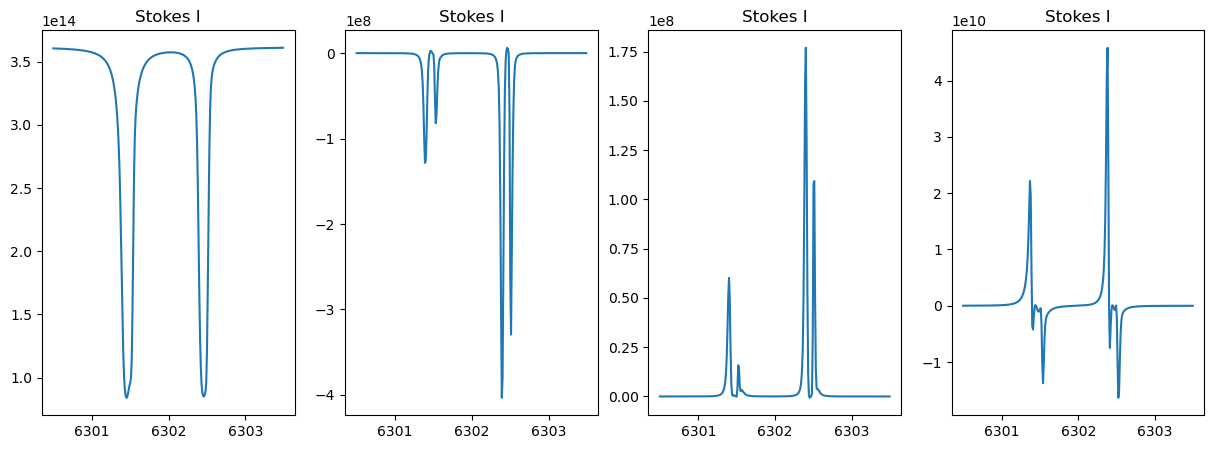

In [ ]:
wl_pix = 0 #pixel in the continuum

#Surface plot
fig, ax = plt.subplots(1,4,figsize=(3*5,5))
stokes_titles = ["Stokes I", "Stokes Q", "Stokes U", "Stokes V"] 
for i in range(len(stokes_titles)):
    im = ax[i].imshow(stokes[:,:,wl_pix,i])
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Stokes I")
plt.show()

#Spectral plot
fig, ax = plt.subplots(1,4,figsize=(3*5,5))
stokes_titles = ["Stokes I", "Stokes Q", "Stokes U", "Stokes V"] 
wl = np.arange(6300.5, 6303.5, 0.01)
for i in range(len(stokes_titles)):
    ax[i].plot(wl, stokes[test_x, test_z,:,i])
    ax[i].set_title("Stokes I")
plt.show()

In [ ]:
#We will save the continuum intensity for future procedures developed in the next sections of the notebook
I_63005 = stokes[:,:,0,0]

### 2.5 Optical depth stratification

Let's apply optical depth stratification to our data so that the atmosphere quantities are expressed depending on optical depth instead of geometrical height.

<span style="color: red"><b>Note:</b><span> <span style="color: black">You can apply the optical depth stratificatication over the modified component because we are only applying an interpolation over the optical depth values known for each pixel of the domain.</span>

In [ ]:
opt_len = 20 #Number of optical depth nodes
mags_names = ["T", "rho", "Bq", "Bu", "Bv", "vy"] # atm quantities
print("Applying optical depth stratification...")
opt_depth = np.load(ptm / "opt_depths" / f"optical_depth_{filename}.npy")
#optical depth points
tau_out = ptm / "tau_arrays" / f"array_of_tau_{filename}_{opt_len}_depth_points.npy"
tau = np.linspace(-3, 1, opt_len)
np.save(tau_out, tau)

#optical stratification
opt_mags_interp = {}
opt_mags = np.zeros((nx, nz, opt_len, atm_quant.shape[-1]))
opt_mags_out =ptm / "stratified_atm" / f"optical_stratified_atm_modified_mbvuq_{filename}_{opt_len}_depth_points_{atm_quant.shape[-1]}_components.npy"
if not os.path.exists(opt_mags_out):
    for ix in tqdm(range(nx)):
            for iz in range(nz):
                for i in range(len(mags_names)):
                    opt_mags_interp[mags_names[i]] = interp1d(opt_depth[test_x,:, test_z], atm_quant[test_x, test_z,:,i])
                    opt_mags[test_x, test_z,:,i] = opt_mags_interp[mags_names[i]](tau)
    np.save(opt_mags_out, opt_mags)
else:
    opt_mags = np.load(opt_mags_out)
atm_quant = opt_mags
print(opt_mags.shape)

Applying optical depth stratification...
(480, 480, 20, 6)


Let's see how the stratification looks

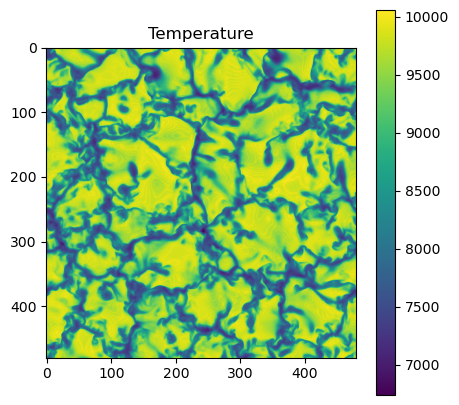

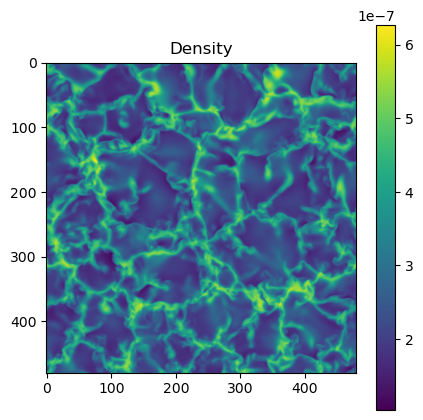

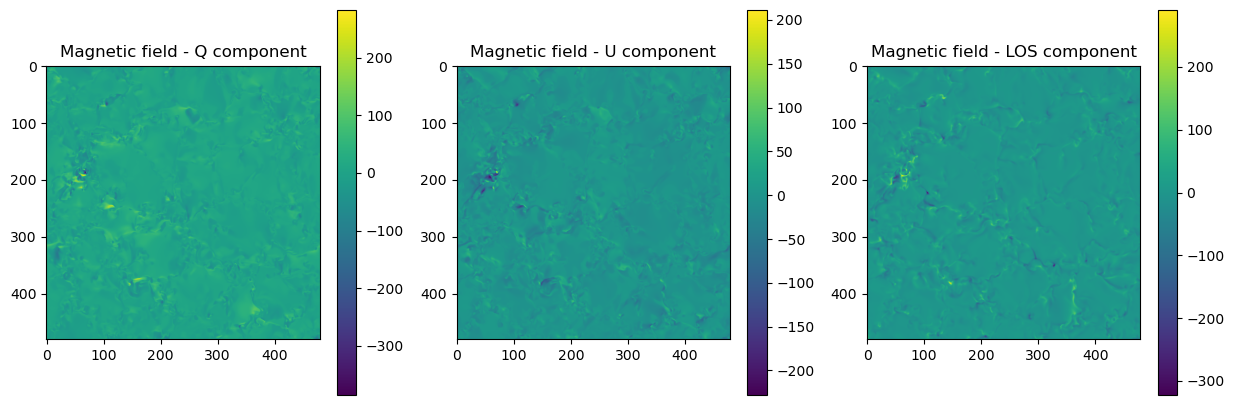

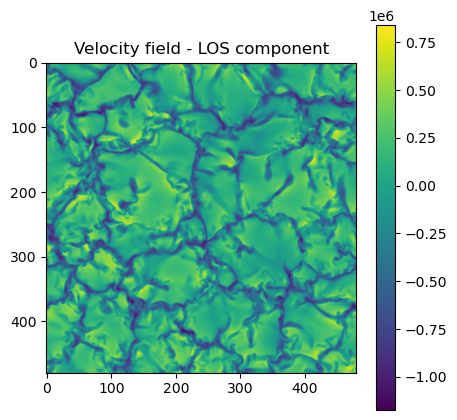

In [ ]:
#Plot over a surface
opt_pix = 10
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(atm_quant[:,:,opt_pix,0])
ax.set_title("Temperature")
fig.colorbar(im, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(atm_quant[:,:,opt_pix,1])
ax.set_title("Density")
fig.colorbar(im, ax=ax)
plt.show()

fig, ax = plt.subplots(1,3,figsize=(3*5,5))
im1 = ax[0].imshow(atm_quant[:,:,opt_pix,2])
fig.colorbar(im1, ax=ax[0])
ax[0].set_title("Magnetic field - Q component")
im2 = ax[1].imshow(atm_quant[:,:,opt_pix,3])
fig.colorbar(im2, ax=ax[1])
ax[1].set_title("Magnetic field - U component")
im3 = ax[2].imshow(atm_quant[:,:,opt_pix,4])
fig.colorbar(im3, ax=ax[2])
ax[2].set_title("Magnetic field - LOS component")
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(atm_quant[:,:,opt_pix,5])
ax.set_title("Velocity field - LOS component")
fig.colorbar(im, ax=ax)
plt.show()



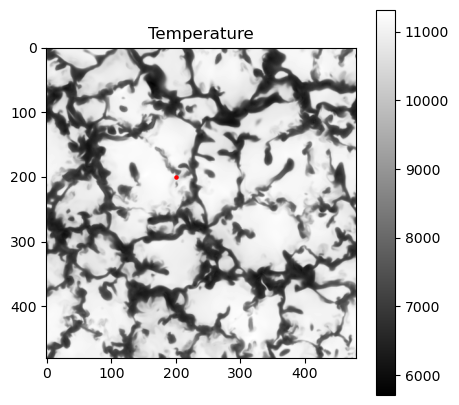

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
test_x, test_z = [200, 200]
im = ax.imshow(mtpr.reshape(nx, ny, nz)[:,height_pix,:], cmap="gist_gray")
ax.scatter(test_x, test_z, s = 5, color = "red")
ax.set_title("Temperature")
fig.colorbar(im, ax=ax)
plt.show()

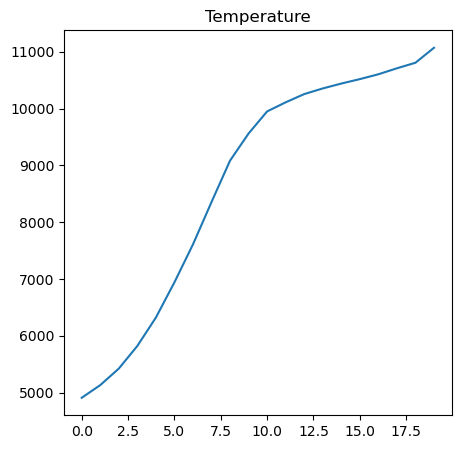

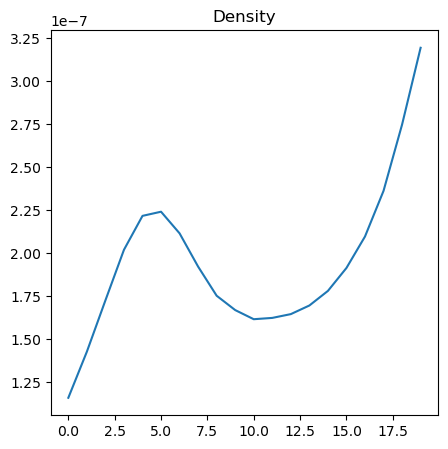

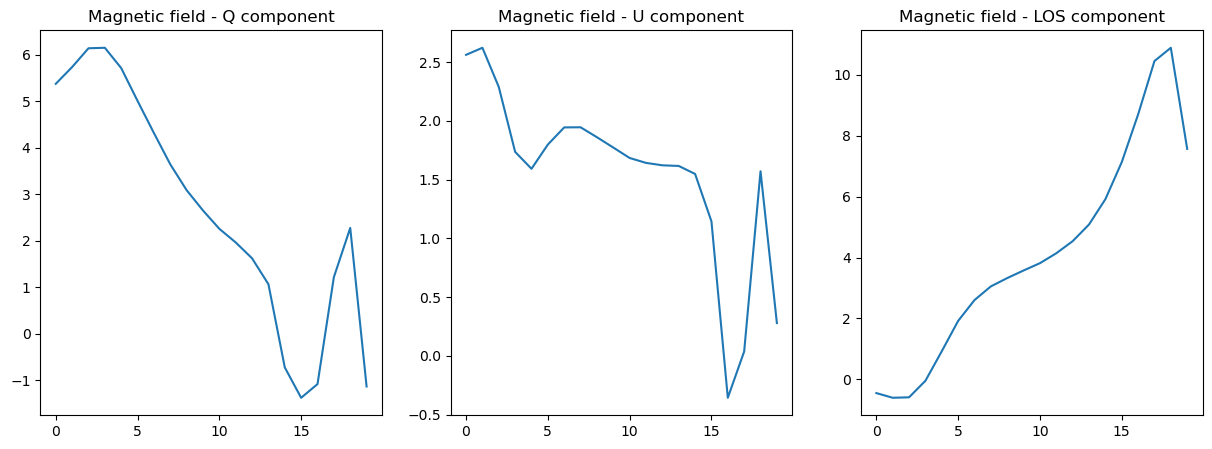

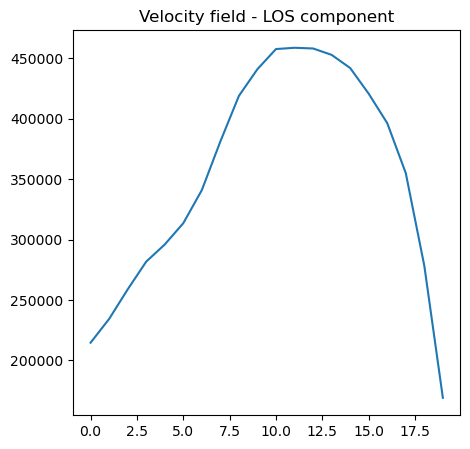

In [ ]:
#Plot over a height
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(atm_quant[test_x, test_z,:,0])
ax.set_title("Temperature")
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(atm_quant[test_x, test_z,:,1])
ax.set_title("Density")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(3*5,5))
ax[0].plot(atm_quant[test_x, test_z,:,2])
ax[0].set_title("Magnetic field - Q component")
ax[1].plot(atm_quant[test_x, test_z,:,3])
ax[1].set_title("Magnetic field - U component")
ax[2].plot(atm_quant[test_x, test_z,:,4])
ax[2].set_title("Magnetic field - LOS component")
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(atm_quant[test_x, test_z,:,5])
ax.set_title("Velocity field - LOS component")
plt.show()

### 2.5 Degrading spectral resolution

The spectral resolution on satellites doing spectropolarimetric measurements on the sun has, as best, 112 points of spectral resolution. This means that it is necessary to degrade the 300 spectral points we have. For this, we are going to apply convolution with a gaussian LSF.

In [ ]:
#Number of spectral points
new_points = 36
# New spectral resolution arrays
new_resol = np.linspace(0,288,new_points, dtype=np.int64)
new_resol = np.add(new_resol, 6)
#File to save the degraded stokes
new_stokes_out = ptm / "resampled_stokes" / f"resampled_stokes_f{filename}_sr{new_points}_wl_points.npy"

#Degradation process
if not os.path.exists(new_stokes_out):

    # Gaussian LSF kernel definition
    N_kernel_points = 13 # number of points of the kernel.
    def gauss(n=N_kernel_points,sigma=1):
        r = range(-int(n/2),int(n/2)+1)
        return np.array([1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-float(x)**2/(2*sigma**2)) for x in r])
    g = gauss()

    

    #Convolution
    print("Degrading...")
    new_stokes = np.zeros((nx, nz, new_points, stokes.shape[-1]))
    
    for s in range(stokes.shape[-1]):
        for jx in tqdm(range(nx)):
            for jz in range(nz):
                spectrum = stokes[jx, jz,:,s]
                resampled_spectrum = np.zeros(new_points)
                i = 0
                for center_wl in new_resol:
                    low_limit = center_wl-6
                    upper_limit = center_wl+7

                    if center_wl == 6:
                        shorten_spect = spectrum[0:13]
                    elif center_wl == 294:
                        shorten_spect = spectrum[-14:-1]
                    else:
                        shorten_spect = spectrum[low_limit:upper_limit]

                    resampled_spectrum[i] = np.sum(np.multiply(shorten_spect,g))
                    i += 1
                new_stokes[jx, jz,:,s] = resampled_spectrum
    np.save(new_stokes_out, new_stokes)
else:
    new_stokes = np.load(new_stokes_out)
    print("stokes degraded!")
stokes = new_stokes

Degrading...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [00:40<00:00, 11.99it/s]


In [ ]:
stokes.shape

(480, 480, 36, 4)

Let's plot the results

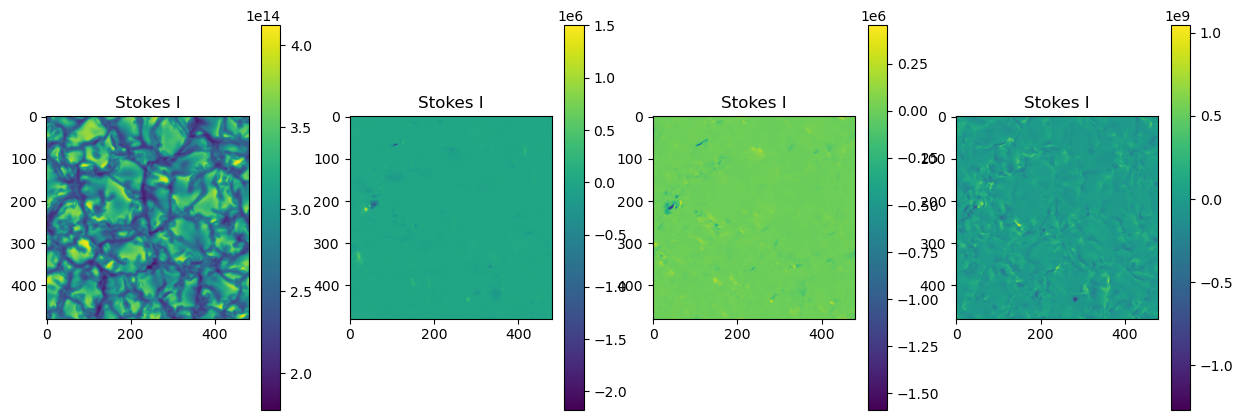

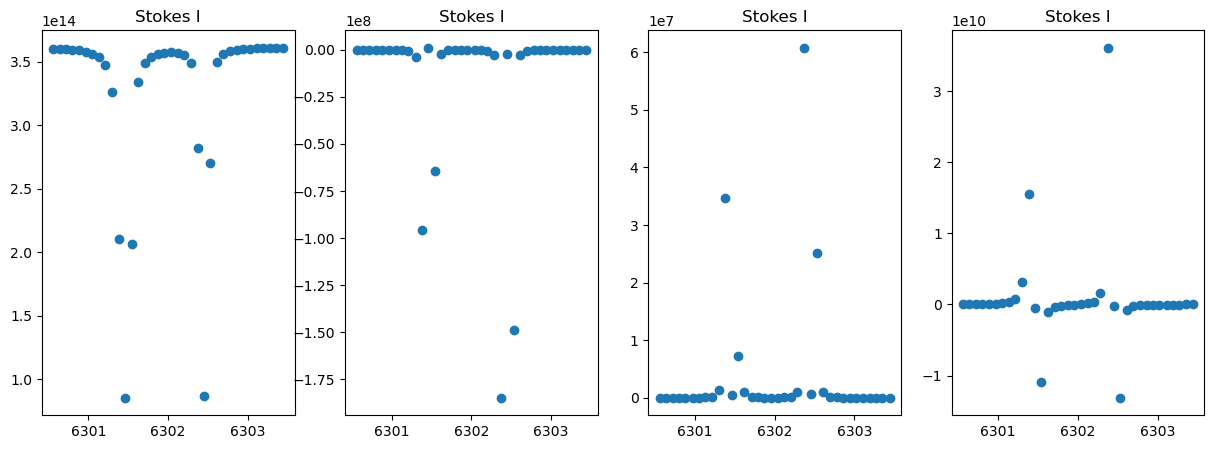

In [ ]:
new_wl = (new_resol*0.01)+6300.5
wl_pix = 0 #pixel in the continuum

#Surface plot
fig, ax = plt.subplots(1,4,figsize=(3*5,5))
stokes_titles = ["Stokes I", "Stokes Q", "Stokes U", "Stokes V"] 
for i in range(len(stokes_titles)):
    im = ax[i].imshow(stokes[:,:,wl_pix,i])
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Stokes I")
plt.show()

#Spectral plot
fig, ax = plt.subplots(1,4,figsize=(3*5,5))
stokes_titles = ["Stokes I", "Stokes Q", "Stokes U", "Stokes V"] 
wl = np.arange(6300.5, 6303.5, 0.01)
for i in range(len(stokes_titles)):
    ax[i].scatter(new_wl, stokes[test_x, test_z,:,i])
    ax[i].set_title("Stokes I")
plt.show()

### 2.5 Scale the data

For the data to be treated by the neural network models, it is necessary to scale it. First, let's check the values of the magnitudes so that we are sure they were correctly scaled.

In [ ]:
print(f""" STOKES:
I_max = {np.max(stokes[:,:,:,0])}
Q_max = {np.max(stokes[:,:,:,1])}
U_max = {np.max(stokes[:,:,:,2])}
V_max = {np.max(stokes[:,:,:,3])}
I_min = {np.min(stokes[:,:,:,0])}
Q_min = {np.min(stokes[:,:,:,1])}
U_min = {np.min(stokes[:,:,:,2])}
V_min = {np.min(stokes[:,:,:,3])}
""")

print(f"""
MAX VALUES:
mtpr max = {np.max(atm_quant[:,:,:,0])}
mrho max = {np.max(atm_quant[:,:,:,1])}
mbqq max = {np.max(atm_quant[:,:,:,2])}
mbuu max = {np.max(atm_quant[:,:,:,3])}
mbvv max = {np.max(atm_quant[:,:,:,4])}
mvyy max = {np.max(atm_quant[:,:,:,5])}
    """)

print(f"""
MIN VALUES:
mtpr min = {np.min(atm_quant[:,:,:,0])}
mrho min = {np.min(atm_quant[:,:,:,1])}
mbqq min = {np.min(atm_quant[:,:,:,2])}
mbuu min = {np.min(atm_quant[:,:,:,3])}
mbvv min = {np.min(atm_quant[:,:,:,4])}
mvyy min = {np.min(atm_quant[:,:,:,5])}
    """) 

 STOKES:
I_max = 412528257732613.25
Q_max = 103074009374.81137
U_max = 35056941902.77085
V_max = 1974573168024.2239
I_min = 23441386696431.18
Q_min = -143268609482.05707
U_min = -143124518135.99756
V_min = -2065595378962.5303


MAX VALUES:
mtpr max = 12312.816061127873
mrho max = 1.1635103186401182e-06
mbqq max = 487.7623270869893
mbuu max = 261.3680491689056
mbvv max = 471.1443671596016
mvyy max = 881866.1903469834
    

MIN VALUES:
mtpr min = 4413.439568816388
mrho min = 6.610200715665868e-08
mbqq min = -387.8831218470229
mbuu min = -324.3338907927663
mbvv min = -436.2772025264331
mvyy min = -1375743.8677228198
    


Now, let's define the scaling factors. For the Stokes parameters we will normalize by the continuum of the intensity, while for the atmospheric magnitudes we will use scale factors determined in terms of the mean maximum and minimum values of each magnitude along all the steps of the simulation. This study is shown [in this other notebook](./Check_data.ipynb).

In [ ]:
#Atmosphere magnitudes scale factors
phys_maxmin = {}
phys_maxmin["T"] = [2e4, 0]
phys_maxmin["B"] = [3e3, -3e3]
phys_maxmin["Rho"] = [1e-5, 1e-10]
phys_maxmin["V"] = [1e6, -1e6]

Let's define a minmax normalizing function.

In [ ]:
def norm_func(arr, maxmin):
    max_val = maxmin[0]
    min_val = maxmin[1]
    return (arr-min_val)/(max_val-min_val)

For the normalization by the continuum it is necessary to establish a function that should describe the behaviour of the intensity without the absorption lines, and this is done by applying an spline interpolation function over the corresponding wavelength values that seem to not show absorption or emiting behaviours.

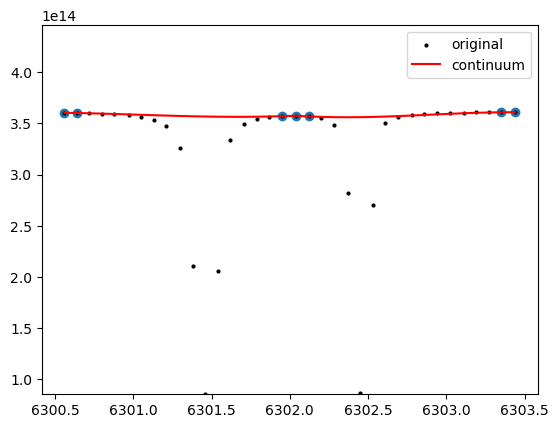

In [ ]:
#Selection of the indices that we assume generally correspond to continuum in our data.
cont_indices = [0,1,int(len(new_wl)/2)-1,int(len(new_wl)/2),int(len(new_wl)/2)+1,-2,-1]


wl_cont_values = new_wl[cont_indices] #corresponding wavelength values to the selected continuum indices
cont_values = stokes[test_x, test_z,cont_indices,0] #corresponding intensity values to the selected continuum indices

cont_model = interp1d(wl_cont_values, cont_values, kind="cubic") #Interpolation applied over the assumed continuum values

fig, ax = plt.subplots()
ax.scatter(wl_cont_values, cont_values)
ax.scatter(new_wl, stokes[test_x, test_z, :, 0], label = "original", color = "black", s = 4)
ax.plot(new_wl, cont_model(new_wl), label="continuum", color = "red")
ymin = np.min(stokes[test_x, test_z,:,0])
ymax = np.max(stokes[test_x, test_z,:,0])
ax.set_ylim((ymin, ymax+ymin))
ax.legend()

Having both the scale factors and the algorithm for finding the continuum model in each pixel...let's normalize the data!

In [ ]:
#Atmosphere magnitudes normalization
atm_quant[:,:,:,0] = norm_func(atm_quant[:,:,:,0], phys_maxmin["T"])

atm_quant[:,:,:,1] = norm_func(atm_quant[:,:,:,1], phys_maxmin["Rho"])

atm_quant[:,:,:,2] = norm_func(atm_quant[:,:,:,2], phys_maxmin["B"])
atm_quant[:,:,:,3] = norm_func(atm_quant[:,:,:,3], phys_maxmin["B"])
atm_quant[:,:,:,4] = norm_func(atm_quant[:,:,:,4], phys_maxmin["B"])

atm_quant[:,:,:,5] = norm_func(atm_quant[:,:,:,5], phys_maxmin["V"])

#Stokes parameter normalization by the continuum
scaled_stokes = np.ones_like(stokes)
cont_indices = [0,1,int(len(new_wl)/2)-1,int(len(new_wl)/2),int(len(new_wl)/2)+1,-2,-1]
wl_cont_values = new_wl[cont_indices] #corresponding wavelength values to the selected continuum indices

for jx in range(nx):
    for jz in range(nz):
        for i in range(stokes.shape[-1]):
            cont_values = stokes[jx, jz,cont_indices,0] #corresponding intensity values to the selected continuum indices
            
            cont_model = interp1d(wl_cont_values, cont_values, kind="cubic") #Interpolation applied over the assumed continuum values

            scaled_stokes[jx, jz,:,i] = stokes[jx, jz,:,i]/cont_model(new_wl)
stokes = scaled_stokes

scaling_importance = [1, 10, 10, 10] #Stokes parameters importance levels -> mapping Q, U and V to 0.1 of the intensity scale
for i in range(len(scaling_importance)):
    stokes[:,:,:,i] = stokes[:,:,:,i]*scaling_importance[i] #####THIS LINE HAS NOT BEEN RUN ON THE CLUSTER!!!!!!!!!!!!!!!11 THAT IS WHY YOU DON'T SEE THE EFFECT OF THE SCALING IN THE PLOTS

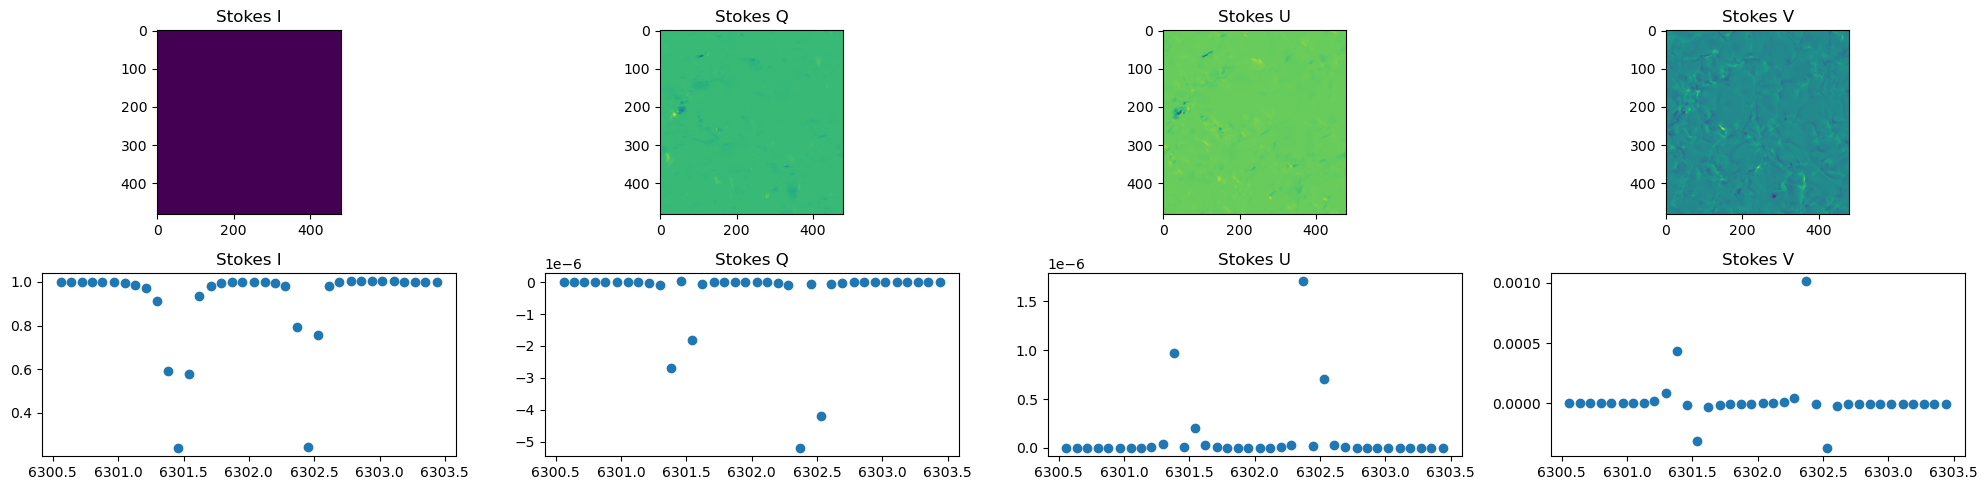

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(4*5,5))
for i in range(4):
    ax[0,i].imshow(stokes[:,:,0,i])
    ax[0,i].set_title(stokes_titles[i])
    ax[1,i].scatter(new_wl, stokes[test_x, test_z,:,i])
    ax[1,i].set_title(stokes_titles[i])
fig.tight_layout()

Let's check the new maximum and minimum values.

In [ ]:
print(f""" STOKES:
I_max = {np.max(stokes[:,:,:,0])}
Q_max = {np.max(stokes[:,:,:,1])}
U_max = {np.max(stokes[:,:,:,2])}
V_max = {np.max(stokes[:,:,:,3])}
I_min = {np.min(stokes[:,:,:,0])}
Q_min = {np.min(stokes[:,:,:,1])}
U_min = {np.min(stokes[:,:,:,2])}
V_min = {np.min(stokes[:,:,:,3])}
""")

print(f"""
MAX VALUES:
mtpr max = {np.max(atm_quant[:,:,:,0])}
mrho max = {np.max(atm_quant[:,:,:,1])}
mbqq max = {np.max(atm_quant[:,:,:,2])}
mbuu max = {np.max(atm_quant[:,:,:,3])}
mbvv max = {np.max(atm_quant[:,:,:,4])}
mvyy max = {np.max(atm_quant[:,:,:,5])}
    """)

print(f"""
MIN VALUES:
mtpr min = {np.min(atm_quant[:,:,:,0])}
mrho min = {np.min(atm_quant[:,:,:,1])}
mbqq min = {np.min(atm_quant[:,:,:,2])}
mbuu min = {np.min(atm_quant[:,:,:,3])}
mbvv min = {np.min(atm_quant[:,:,:,4])}
mvyy min = {np.min(atm_quant[:,:,:,5])}
    """) 

 STOKES:
I_max = 1.0151412526843329
Q_max = 0.0030193287626227886
U_max = 0.0012123495722728421
V_max = 0.06255396247315238
I_min = 0.07302341026566779
Q_min = -0.006028875976268503
U_min = -0.004312762143926566
V_min = -0.06981067202315486


MAX VALUES:
mtpr max = 0.6156408030563937
mrho max = 0.11634219528596466
mbqq max = 0.581293721181165
mbuu max = 0.5435613415281509
mbvv max = 0.5785240611932669
mvyy max = 0.9409330951734917
    

MIN VALUES:
mtpr min = 0.22067197844081937
mrho min = 0.0066002667183330515
mbqq min = 0.4353528130254962
mbuu min = 0.44594435153453893
mbvv min = 0.42728713291226117
mvyy min = -0.1878719338614099
    


In [ ]:
atm_quant.shape, stokes.shape

((480, 480, 20, 6), (480, 480, 36, 4))

### 2.6 Filtering the data by granular and intergranular zones

Granular and intergranular regions has different physicial behaviou, meaning that if we want to assess correctly the information on the calm sun we must balance the data we have over this two regions, meaning that we need to have the same amount on data on both. For this, we will apply a threshold used in computer vision for separating _foreground_ from _background_ over the intensity outside of the absorption lines. This parameter was selected in previous sections as the first value of the spectra over each pixel.

Text(0.5, 1.0, 'Intensity in the continuum')

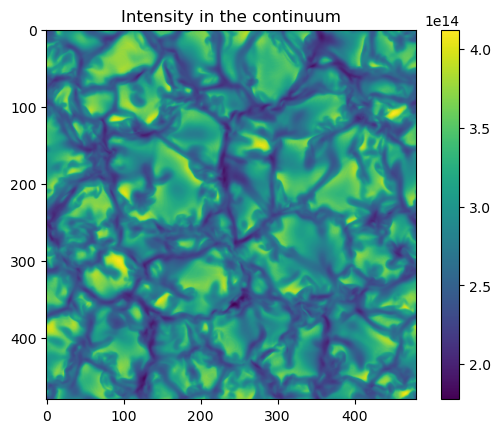

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(I_63005)
fig.colorbar(im, ax = ax)
ax.set_title("Intensity in the continuum")

Having the intensity in the continuum, let's apply the Otsu's threshold and check how the separation looks like

In [ ]:
#Threshold definition
thresh1 = filters.threshold_otsu(I_63005)

#Mask extraction
im_bin = I_63005<thresh1
gran_mask =  np.ma.masked_array(I_63005, mask=im_bin).mask
inter_mask = np.ma.masked_array(I_63005, mask=~im_bin).mask

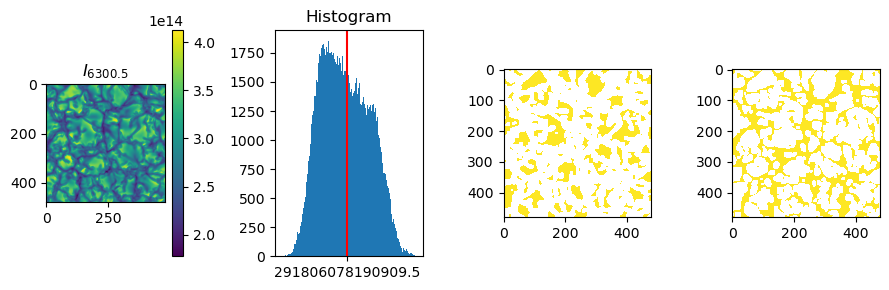

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (3*3,3))


im = ax[0].imshow(I_63005)
fig.colorbar(im, ax=ax[0])
ax[0].set_title(r"$I_{6300.5}$")
ax[1].hist(I_63005.ravel(), bins=256)
ax[1].set_xticks([thresh1], [thresh1])
ax[1].set_title('Histogram')
ax[1].axvline(thresh1, color='r')
ax[2].imshow(np.ma.masked_array(I_63005, mask=im_bin), vmin = 0, vmax = 1)
ax[3].imshow(np.ma.masked_array(I_63005, mask=~im_bin), vmin = 0, vmax = 1)

fig.tight_layout()
fig.savefig("Otsu_thres_I_stokes.svg", transparent = True)
plt.show()

Having the threshold applied, let's save the atmosphere quantities corresponding to each region.

In [ ]:
#Mask application
atm_quant_gran = atm_quant[gran_mask]
atm_quant_inter = atm_quant[inter_mask]
stokes_gran = stokes[gran_mask]
stokes_inter = stokes[inter_mask]
len_inter = atm_quant_inter.shape[0]
len_gran = atm_quant_gran.shape[0]

In [ ]:
atm_quant_gran.shape, atm_quant_inter.shape, stokes_gran.shape, stokes_inter.shape

((126582, 20, 6), (103818, 20, 6), (126582, 36, 4), (103818, 36, 4))

Having the regions pixels selected, let's balance the amount of data on both of them.

In [ ]:
#leveraging the quantity of data from the granular and intergranular zones by a random dropping of elements of the greater zone.
print("leveraging...")
index_select  = []
np.random.seed(50)
if len_inter < len_gran:
    index_select = np.random.choice(range(len_gran), size = (len_inter,), replace = False)
    atm_quant_leveraged = np.concatenate((atm_quant_gran[index_select], atm_quant_inter), axis = 0)
    stokes_leveraged = np.concatenate((stokes_gran[index_select], stokes_inter), axis = 0)
elif len_inter > len_gran:
    index_select = np.random.choice(range(len_inter), size = (len_gran,), replace = False)
    atm_quant_leveraged = np.concatenate((atm_quant_gran, atm_quant_inter[index_select]), axis = 0)
    stokes_leveraged = np.concatenate((stokes_gran, stokes_inter[index_select]), axis = 0)
print("Done")

leveraging...
Done


In [ ]:
atm_quant_leveraged.shape, stokes_leveraged.shape

((207636, 20, 6), (207636, 36, 4))